# Analysis of Single Cell Data from CSF Project
- Roy Jiang
- June 11, 2020
- Cloning. Clonal overlap. Repertoire analysis for Diversity. Size Change.

# Before running

- This notebook assumes that the processing notebook has completed and changeo files have been generated. It also assumes that you have placed the csf object in the main directory you will be mounting. 

In [ ]:
TENX_META_FILE = "/git/projects/Song2021_CellReports/meta.csv"
ASSIGNMENT_FILE = "/git/projects/Song2021_CellReports/assignments.csv"
CELLRANGER_DIR = "/data/cellranger"
CSF_OBJECT = "/data/csf.rds"

SATURN_SOURCE = "/git/pipeline_abseq/api/saturn/saturn.R"

### Generated by this notebook
OUT_TAB = "/data/out_tcr.tab"

### For outputting figures and tables
BASE_DIR = "/data"
TABLES_DIR <- "/data"

human_ref_dir <- "/usr/local/share/germlines/imgt/human/vdj"

dir.create(file.path(BASE_DIR, "figures"))

# Load libraries

In [1]:
library(shazam)
library(alakazam)
library(ggforce)
library(tidyverse)
library(scales)

Loading required package: ggplot2
As of v1.0.0 the AIRR Rearrangement schema is now the default file format.
A description of the standard is available at https://docs.airr-community.org.
The legacy Change-O format is supported through arguments to each function
that allow the input column names to be explicitly defined.
As of v1.0.0 the AIRR Rearrangement schema is now the default file format.
A description of the standard is available at https://docs.airr-community.org.
The legacy Change-O format is supported through arguments to each function
that allow the input column names to be explicitly defined.
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ tibble  3.0.1     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
✔ purrr   0.3.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: 

In [4]:
source(SATURN_SOURCE)


Attaching package: ‘igraph’

The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union

The following objects are masked from ‘package:purrr’:

    compose, simplify

The following object is masked from ‘package:tidyr’:

    crossing

The following object is masked from ‘package:tibble’:

    as_data_frame

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘lazyeval’

The following objects are masked from ‘package:purrr’:

    is_atomic, is_formula



In [2]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: Fedora 31 (Workstation Edition)

Matrix products: default
BLAS/LAPACK: /usr/lib64/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] scales_1.1.1    forcats_0.4.0   stringr_1.4.0   dplyr_1.0.0    
 [5] purrr_0.3.4     readr_1.3.1     tidyr_1.1.0     tibble_3.0.1   
 [9] tidyverse_1.3.0 ggforce_0.3.1   alakazam_1.0.2  shazam_1.0.1   
[13] ggplot2_3.3.1  

loaded via a namespace (and not attached):
 [1] httr_1.4.1         jsonlite_1.6.1     foreach_1.

In [3]:
enumerateGroup <- function(df, group, index){
    df %>%
        group_by(!!rlang::sym(group)) %>%
        mutate(row_number() == 1) %>%
        ungroup() %>% 
        mutate(!!rlang::sym(index) := cumsum(!!rlang::sym('row_number() == 1'))) %>% return()
}

In [7]:
meta_df <- read.csv(TENX_META_FILE) %>%
    filter(TYPE == 'TCR') %>%
    filter(SAMPLE != 'PBMC6')

In [8]:
meta_df

IDENTITY   SAMPLE SUBJECT STATUS LOCATION TYPE
1  CSF1_TCR   CSF1   P1      N      CSF      TCR 
2  CSF2_TCR   CSF2   P2      N      CSF      TCR 
3  CSF3_TCR   CSF3   P3      N      CSF      TCR 
4  CSF4_TCR   CSF4   P4      N      CSF      TCR 
5  CSF5_TCR   CSF5   P5      N      CSF      TCR 
6  CSFC1_TCR  CSFC1  P6      C      CSF      TCR 
7  CSFC2_TCR  CSFC2  P7      C      CSF      TCR 
8  CSFC3_TCR  CSFC3  P8      C      CSF      TCR 
9  PBMC1_TCR  PBMC1  P1      N      PBMC     TCR 
10 PBMC7_TCR  PBMC7  P2      N      PBMC     TCR 
11 PBMC5_TCR  PBMC5  P3      N      PBMC     TCR 
12 PBMC8_TCR  PBMC8  P4      N      PBMC     TCR 
13 PBMC9_TCR  PBMC9  P5      N      PBMC     TCR 
14 PBMC10_TCR PBMC10 P6      C      PBMC     TCR 
15 PBMC11_TCR PBMC11 P7      C      PBMC     TCR 
16 PBMC12_TCR PBMC12 P8      C      PBMC     TCR 
   PATH                                        
1  /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/TCR
2  /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/TCR
3  /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/TCR
4  /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/TCR
5  /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/TCR
6  /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/TCR
7  /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/TCR
8  /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/TCR
9  /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/TCR
10 /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/TCR
11 /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/TCR
12 /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/TCR
13 /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/TCR
14 /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/TCR
15 /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/TCR
16 /home/ruoyi/Dropbox/Projects/Iwasaki_CSF/TCR

# Processing

In [9]:
hc_df <- meta_df %>%
    rowwise() %>%
    mutate(FILE = file.path(PATH, IDENTITY, "changeo", "filtered_contig_heavy_FUNCTIONAL-T.tab")) %>%
    ungroup() %>%
    select(IDENTITY, FILE) %>%
    group_by(IDENTITY) %>%
    do(read.csv(.$FILE, sep = '\t') %>% mutate_if(is.factor, as.character)) %>% ungroup() %>%
    left_join(meta_df, by="IDENTITY")

lc_df <- meta_df %>%
    rowwise() %>%
    mutate(FILE = file.path(PATH, IDENTITY, "changeo", "filtered_contig_light_FUNCTIONAL-T.tab")) %>%
    ungroup() %>%
    select(IDENTITY, FILE) %>%
    group_by(IDENTITY) %>%
    do(read.csv(.$FILE, sep = '\t') %>% mutate_if(is.factor, as.character)) %>% ungroup() %>%
    left_join(meta_df, by="IDENTITY") 

In [10]:
hc_df %>% group_by(CELL) %>% summarize(COUNT = n()) %>% group_by(COUNT) %>% summarize(COUNT_COUNT = n())

`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)


COUNT COUNT_COUNT
1 1     30907      
2 2      2679      
3 3       122      
4 4         4

In [11]:
dim(hc_df)

[1] 36647    67

In [12]:
hc_df <- hc_df %>%
	group_by(CELL) %>%
	filter(UMICOUNT == max(UMICOUNT)) %>%
	filter(CONSCOUNT == max(CONSCOUNT), n() == 1)

In [13]:
dim(hc_df)

[1] 33505    67

In [14]:
dim(lc_df)

[1] 31034    67

In [15]:
lc_df %>% group_by(CELL) %>% summarize(COUNT = n()) %>% group_by(COUNT) %>% summarize(COUNT_COUNT = n())

`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)


COUNT COUNT_COUNT
1 1     24667      
2 2      2989      
3 3       119      
4 4         8

In [16]:
lc_df <- lc_df %>%
    group_by(CELL) %>%
    filter(UMICOUNT == max(UMICOUNT)) %>%
    filter(CONSCOUNT == max(CONSCOUNT), n() == 1) %>%
    select(CELL, SEQUENCE_IMGT) %>%
    rename(SEQUENCE_TCRA = SEQUENCE_IMGT)

In [17]:
dim(lc_df)

[1] 27230     2

In [18]:
hc_df <- hc_df %>%
    left_join(lc_df) %>%
    mutate(CLONE = paste0(SEQUENCE_IMGT, SEQUENCE_TCRA))

Joining, by = "CELL"


In [19]:
hc_df %>% filter(is.na(SEQUENCE_TCRA)) %>% dim()

[1] 7069   69

In [20]:
hc_df <- hc_df %>% 
    enumerateGroup("CLONE", "CLONE")

In [21]:
hc_df <- hc_df %>%
    group_by(CLONE, SUBJECT) %>%
    mutate(SPAN = if(length(unique(LOCATION)) == 2){"Mobile"}else{"Resident"}) %>% ungroup()

In [23]:
hc_df <- hc_df %>%
    rowwise() %>%
    mutate(SUBJECT_LOCATION = paste(SUBJECT, LOCATION, sep = ',')) %>% ungroup()

### Assign Clusters

In [27]:
assignment_df <- read.csv(ASSIGNMENT_FILE) %>%
    select(-DESCRIPTION) %>%
    mutate(CLUSTER = as.character(CLUSTER))

obj <- readRDS(CSF_OBJECT)

identity_df <- data.frame(CLUSTER = obj@active.ident) %>%
    tibble::rownames_to_column("CELL") %>%
    rowwise() %>%
    mutate(CELL = paste0(strsplit(CELL, split = "_")[[1]][1], "-1")) %>%
    mutate(CLUSTER = strsplit(as.character(CLUSTER), split = '_')[[1]][1]) %>%
    ungroup() %>%
    mutate(SAMPLE=obj@meta.data$orig.ident) %>%
    mutate(SAMPLE=gsub("_", "", SAMPLE)) %>%
    left_join(assignment_df)

hc_df <- hc_df %>%
    left_join(identity_df %>%
        select(CELL, SAMPLE, SUBSET) %>% mutate(GEX = TRUE)) 

Joining, by = "CLUSTER"
Joining, by = c("CELL", "SAMPLE")


In [28]:
identity_df %>%
    left_join(hc_df %>%
        select(CELL, SAMPLE, C_CALL) %>% mutate(VDJ = TRUE)) %>%
    filter(SUBSET == "CD8 T cell") %>%
    group_by(SAMPLE, VDJ) %>%
    summarize(COUNT = n()) %>%
    group_by(SAMPLE) %>%
    mutate(FREQ = COUNT/sum(COUNT)) %>% filter(VDJ)

Joining, by = c("CELL", "SAMPLE")
`summarise()` regrouping output by 'SAMPLE' (override with `.groups` argument)


SAMPLE VDJ  COUNT FREQ     
1  CSF1   TRUE  882  0.9197080
2  CSF2   TRUE   60  0.9230769
3  CSF3   TRUE   34  0.7234043
4  CSF4   TRUE  920  0.9445585
5  CSF5   TRUE   87  0.9255319
6  CSFC1  TRUE 1499  0.9051932
7  CSFC2  TRUE 1040  0.9090909
8  CSFC3  TRUE  953  0.8671520
9  PBMC1  TRUE  228  0.5743073
10 PBMC10 TRUE 1212  0.8493343
11 PBMC11 TRUE  653  0.7378531
12 PBMC12 TRUE 1225  0.8048620
13 PBMC5  TRUE  802  0.7681992
14 PBMC7  TRUE  320  0.8000000
15 PBMC8  TRUE 1117  0.7276873
16 PBMC9  TRUE  532  0.8248062

### Read/write

In [34]:
hc_df %>% 
    write.table(OUT_TAB, sep="\t")

In [9]:
hc_df <- read.csv(OUT_TAB, sep="\t")

# Bray-Curtis Overlap

In [35]:
overlap_df <- hc_df %>%
    filter(SUBSET == "CD8 T cell") %>%
    group_by(SUBJECT) %>%
    do(runQuantifyOverlap(., group="LOCATION", clone="CLONE", action="sorenson_bool")  
       %>% mutate_if(is.factor, as.character))

In [36]:
overlap_df <- overlap_df %>% 
    filter(!(index != 'CSF' & LOCATION != 'PBMC'), index != LOCATION) %>% ungroup()

Joining, by = "SUBJECT"


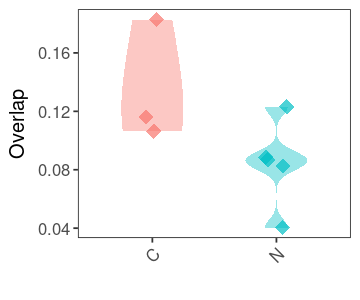

In [37]:
p <- overlap_df %>%
    left_join(
        meta_df %>% select(SUBJECT, STATUS) %>% distinct()
    ) %>% ggplot(aes(x=STATUS, y=OVERLAP)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Overlap")) +
    geom_violin(aes(fill=STATUS), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_point(aes(color=STATUS), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7)
plot(p)
    

In [38]:
overlap_df <- hc_df %>%
    filter(SUBSET == "CD4 T cell") %>%
    group_by(SUBJECT) %>%
    do(runQuantifyOverlap(., group="LOCATION", clone="CLONE", action="sorenson_bool")  
       %>% mutate_if(is.factor, as.character))

In [39]:
overlap_df <- overlap_df %>% 
    filter(!(index != 'CSF' & LOCATION != 'PBMC'), index != LOCATION) %>% ungroup()

Joining, by = "SUBJECT"


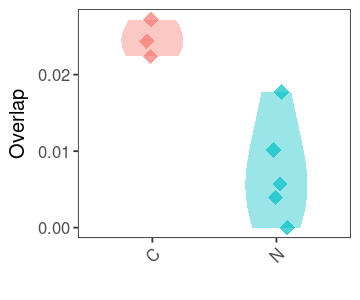

In [40]:
p <- overlap_df %>%
    left_join(
        meta_df %>% select(SUBJECT, STATUS) %>% distinct()
    ) %>% ggplot(aes(x=STATUS, y=OVERLAP)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Overlap")) +
    geom_violin(aes(fill=STATUS), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_point(aes(color=STATUS), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7)
plot(p)
    

### CD8 T cell VD

In [46]:
overlap_df <- hc_df %>%
    filter(SUBSET == "CD8 T cell") %>%
    group_by(SUBJECT) %>%
    do(runQuantifyOverlap(., group="LOCATION", clone="CLONE", action="count_bool")  
       %>% mutate_if(is.factor, as.character))

In [47]:
overlap_df <- overlap_df %>% 
    filter(!(index != 'CSF' & LOCATION != 'PBMC'))

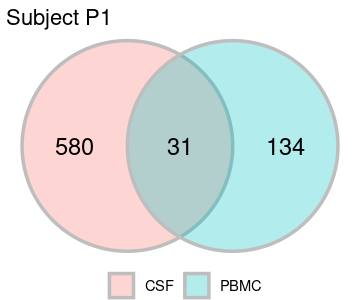

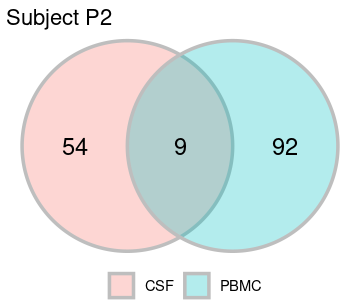

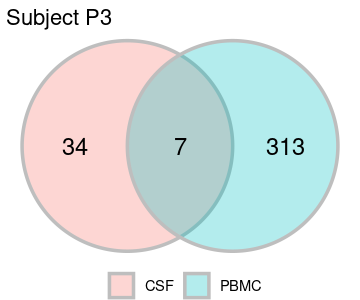

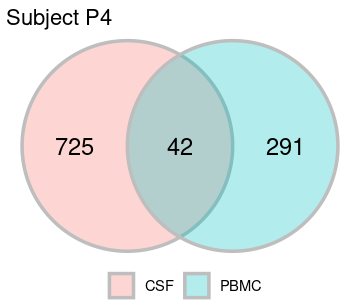

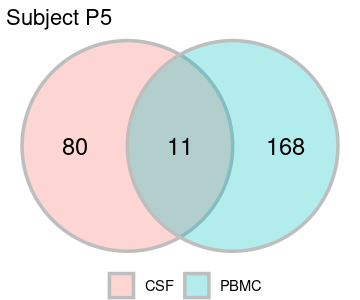

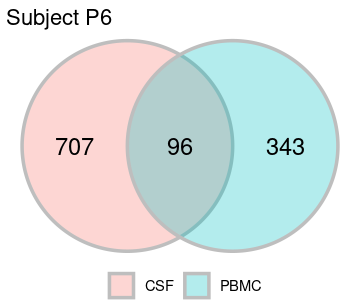

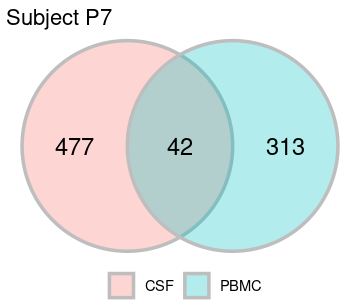

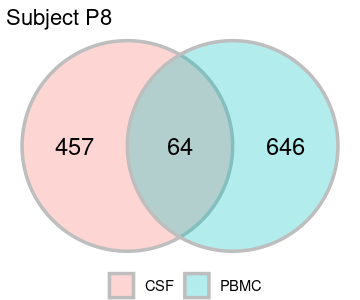

In [50]:
df.venn <- data.frame(x = c(-0.5, 0.5),
                          y = c(0,0),
                          labels = c("CSF", "PBMC"))

df.vdc <- data.frame(x = c(-1, 0, 1),
                       y = c(0,0,0))

for(subj in unique(meta_df$SUBJECT)){
    df.vdc <- df.vdc %>%
        mutate(label = overlap_df %>% ungroup() %>% filter(SUBJECT == subj) %>% select(OVERLAP) %>% unlist())
    
    options(repr.plot.width=3, repr.plot.height=2.5)
    p <- ggplot(df.venn) +
        geom_circle(aes(x0 = x, y0 = y, r = 1, fill = labels), alpha = .3, size = 1, colour = 'grey') +
        coord_fixed() +
        theme_void() +
        ggtitle(paste("Subject", subj)) +
         theme(legend.position = 'bottom') +
    #   scale_fill_manual(values = TIME_COLORS) +
    #   scale_colour_manual(values = TIME_COLORS, guide = FALSE) +
          labs(fill = NULL) +
        annotate("text", x = df.vdc$x, y = df.vdc$y, label = df.vdc$label, size = 5)
    plot(p)
}

### CD4 T cell VD

In [56]:
overlap_df <- hc_df %>%
    filter(SUBSET == "CD4 T cell") %>%
    group_by(SUBJECT) %>%
    do(runQuantifyOverlap(., group="LOCATION", clone="CLONE", action="count_bool")  
       %>% mutate_if(is.factor, as.character))

In [57]:
overlap_df <- overlap_df %>% 
    filter(!(index != 'CSF' & LOCATION != 'PBMC')) %>% ungroup()

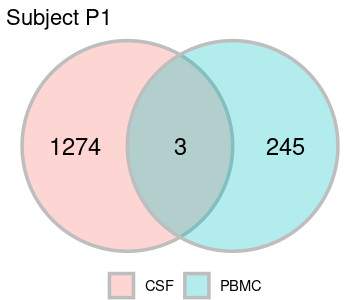

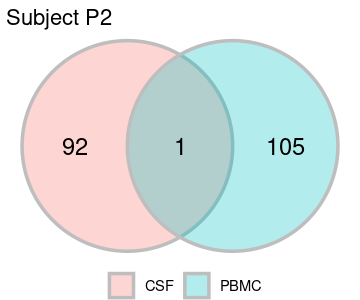

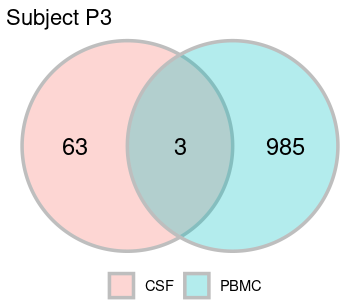

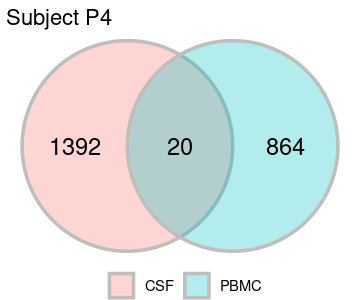

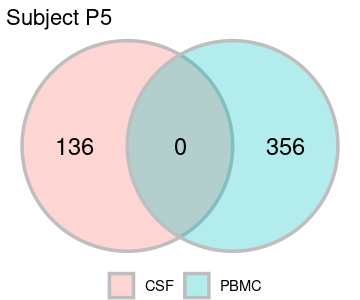

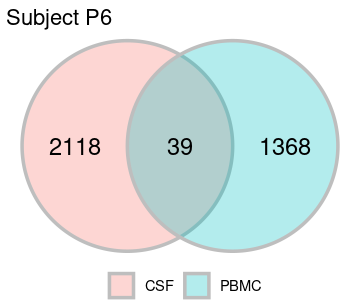

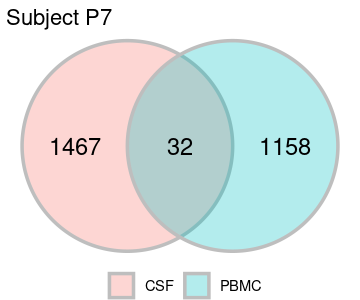

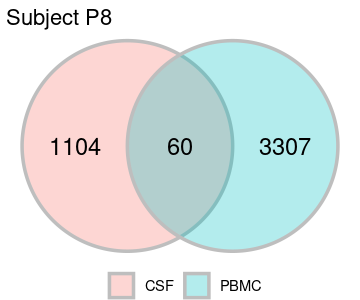

In [60]:
df.venn <- data.frame(x = c(-0.5, 0.5),
                          y = c(0,0),
                          labels = c("CSF", "PBMC"))

df.vdc <- data.frame(x = c(-1, 0, 1),
                       y = c(0,0,0))

for(subj in unique(meta_df$SUBJECT)){
    df.vdc <- df.vdc %>%
        mutate(label = overlap_df %>% ungroup() %>% filter(SUBJECT == subj) %>% select(OVERLAP) %>% unlist())
    
    options(repr.plot.width=3, repr.plot.height=2.5)
    p <- ggplot(df.venn) +
        geom_circle(aes(x0 = x, y0 = y, r = 1, fill = labels), alpha = .3, size = 1, colour = 'grey') +
        coord_fixed() +
        theme_void() +
        ggtitle(paste("Subject", subj)) +
         theme(legend.position = 'bottom') +
    #   scale_fill_manual(values = TIME_COLORS) +
    #   scale_colour_manual(values = TIME_COLORS, guide = FALSE) +
          labs(fill = NULL) +
        annotate("text", x = df.vdc$x, y = df.vdc$y, label = df.vdc$label, size = 5)
    plot(p)
}

# Features of the compartments CD8

### Sizes of clones mobile vs resident CD8

In [65]:
abund <- estimateAbundance(hc_df %>% filter(SUBSET == "CD8 T cell"), 
                           group="SUBJECT_LOCATION", clone="CLONE", ci=0.95, nboot=2000, min_n=10)



`summarise()` regrouping output by 'SUBJECT_LOCATION' (override with `.groups` argument)
Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(clone)` instead of `clone` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
`summarise()` ungrouping output (override with `.groups` argument)


In [66]:
abund <- abund@abundance %>%
    rowwise() %>%
    mutate(SUBJECT = strsplit(SUBJECT_LOCATION, ",")[[1]][1],
          LOCATION = strsplit(SUBJECT_LOCATION, ",")[[1]][2]
          ) %>%
    left_join(meta_df %>% select(SUBJECT, STATUS) %>% distinct())

Joining, by = "SUBJECT"


In [67]:
abund_span <- abund %>% filter(!grepl("U", CLONE)) %>%
    mutate(CLONE = as.integer(CLONE)) %>%
    left_join(
        hc_df %>%
            select(CLONE, SUBJECT, LOCATION, SPAN) %>% distinct()
    )

Joining, by = c("CLONE", "SUBJECT", "LOCATION")


`summarise()` regrouping output by 'SUBJECT', 'LOCATION', 'STATUS' (override with `.groups` argument)
Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”

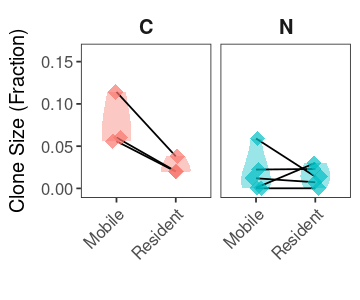

In [69]:
options(repr.plot.width=3, repr.plot.height=2.5)
abund_span %>%
    group_by(SUBJECT, LOCATION, STATUS, SPAN)%>%
    summarize(P = max(P)) %>% filter(LOCATION == "CSF") %>%
    ggplot(aes(x=SPAN, y=P)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Clone Size (Fraction)")) +
    scale_y_continuous(expand = expand_scale(mult = c(0.1, 0.5))) +
    geom_violin(aes(fill=STATUS), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group = SUBJECT)) +
    geom_point(aes(color=STATUS), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_grid(. ~ STATUS)

`summarise()` regrouping output by 'SUBJECT', 'LOCATION', 'STATUS' (override with `.groups` argument)
Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”

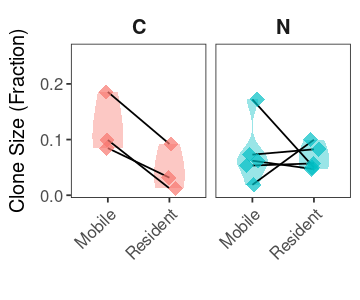

In [70]:
options(repr.plot.width=3, repr.plot.height=2.5)
abund_span %>%
    group_by(SUBJECT, LOCATION, STATUS, SPAN)%>%
    summarize(P = max(P)) %>% filter(LOCATION == "PBMC") %>%
    ggplot(aes(x=SPAN, y=P)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Clone Size (Fraction)")) +
    scale_y_continuous(expand = expand_scale(mult = c(0.1, 0.5))) +
    geom_violin(aes(fill=STATUS), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group = SUBJECT)) +
    geom_point(aes(color=STATUS), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_grid(. ~ STATUS)

### Overall abundances CSF vs PBMC of CD8

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”

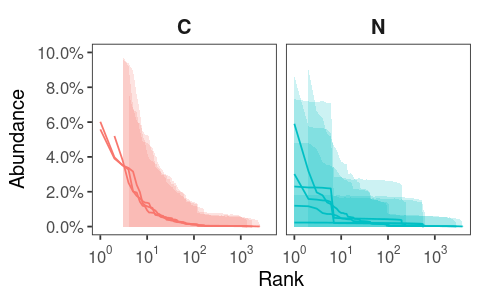

In [73]:
options(repr.plot.width=4, repr.plot.height=2.5)

p <- ggplot(abund %>% filter(LOCATION == "CSF"), aes(x=RANK, y=P, group=SUBJECT)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +
    xlab("Rank") +
    ylab("Abundance") +
    scale_x_log10(breaks=trans_breaks('log10', function(x) 10^x),
                  labels=trans_format('log10', math_format(10^.x))) +
    scale_y_continuous(labels=percent, breaks=seq(0.0, 0.1, 0.02), limits=c(0,0.1)) +
    geom_ribbon(aes(ymin=LOWER, ymax=UPPER, fill=STATUS), alpha=0.2) +
    geom_line(aes(color=STATUS), size=0.5) +
    facet_grid(. ~ STATUS)
plot(p)

Warning message:
“Removed 2 row(s) containing missing values (geom_path).”

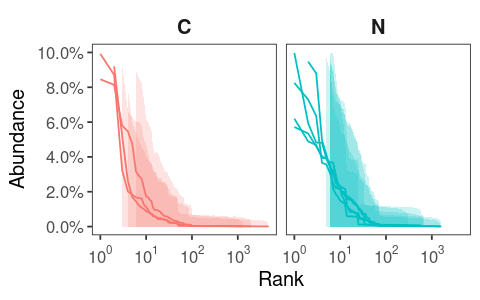

In [74]:
options(repr.plot.width=4, repr.plot.height=2.5)

p <- ggplot(abund %>% filter(LOCATION == "PBMC"), aes(x=RANK, y=P, group=SUBJECT)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +
    xlab("Rank") +
    ylab("Abundance") +
    scale_x_log10(breaks=trans_breaks('log10', function(x) 10^x),
                  labels=trans_format('log10', math_format(10^.x))) +
    scale_y_continuous(labels=percent, breaks=seq(0.0, 0.1, 0.02), limits=c(0,0.10)) +
    geom_ribbon(aes(ymin=LOWER, ymax=UPPER, fill=STATUS), alpha=0.2) +
    geom_line(aes(color=STATUS), size=0.5) +
    facet_grid(. ~ STATUS)
plot(p)

### Overall diversity CSF vs PBMC of CD8

In [75]:
div <- alphaDiversity(hc_df %>% ungroup() %>% filter(SUBSET == "CD8 T cell"), group="SUBJECT_LOCATION", 
                           clone="CLONE", 
                           min_q=0, max_q=2, step_q=2, ci=0.95, nboot=2000, min_n=10)

`summarise()` regrouping output by 'SUBJECT_LOCATION' (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` regrouping output by 'SUBJECT_LOCATION' (override with `.groups` argument)


In [76]:
even <- div@diversity %>%
    mutate(SUBJECT = strsplit(SUBJECT_LOCATION, ",")[[1]][1],
          LOCATION = strsplit(SUBJECT_LOCATION, ",")[[1]][2]
          ) %>%
    left_join(meta_df %>% select(SUBJECT, STATUS) %>% distinct())

Joining, by = "SUBJECT"


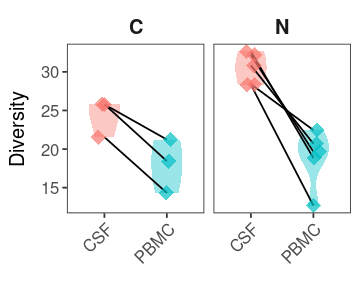

In [78]:
options(repr.plot.width=3, repr.plot.height=2.5)

p <- ggplot(even %>% filter(Q==2), aes(x=LOCATION, y=D)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Diversity")) +
    geom_violin(aes(fill=LOCATION), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group = SUBJECT)) +
    geom_point(aes(color=LOCATION), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_grid(. ~ STATUS)
plot(p)

Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?


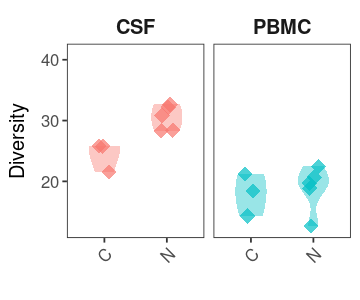

In [79]:
options(repr.plot.width=3, repr.plot.height=2.5)

p <- ggplot(even %>% filter(Q==2), aes(x=STATUS, y=D)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Diversity")) +
    scale_y_continuous(expand = expand_scale(mult = c(0.1, 0.5))) +
    geom_violin(aes(fill=LOCATION), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group = SUBJECT)) +
    geom_point(aes(color=LOCATION), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_grid(. ~ LOCATION)
plot(p)

# Features of the compartments CD4

### Sizes of clones mobile vs resident CD4

In [80]:
abund <- estimateAbundance(hc_df %>% filter(SUBSET == "CD4 T cell"), group="SUBJECT_LOCATION", clone="CLONE", ci=0.95, nboot=200, min_n=10)



`summarise()` regrouping output by 'SUBJECT_LOCATION' (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)


In [81]:
abund <- abund@abundance %>%
    rowwise() %>%
    mutate(SUBJECT = strsplit(SUBJECT_LOCATION, ",")[[1]][1],
          LOCATION = strsplit(SUBJECT_LOCATION, ",")[[1]][2]
          ) %>%
    left_join(meta_df %>% select(SUBJECT, STATUS) %>% distinct())

Joining, by = "SUBJECT"


In [82]:
abund_span <- abund %>% filter(!grepl("U", CLONE)) %>%
    mutate(CLONE = as.integer(CLONE)) %>%
    left_join(
        hc_df %>%
            select(CLONE, SUBJECT, LOCATION, SPAN) %>% distinct()
    )

Joining, by = c("CLONE", "SUBJECT", "LOCATION")


`summarise()` regrouping output by 'SUBJECT', 'LOCATION', 'STATUS' (override with `.groups` argument)
Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”

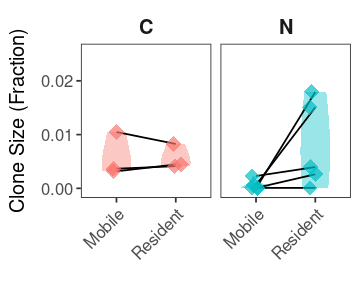

In [83]:
options(repr.plot.width=3, repr.plot.height=2.5)
p <- abund_span %>%
    group_by(SUBJECT, LOCATION, STATUS, SPAN)%>%
    summarize(P = max(P)) %>% filter(LOCATION == "CSF") %>%
    ggplot(aes(x=SPAN, y=P)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Clone Size (Fraction)")) +
    scale_y_continuous(expand = expand_scale(mult = c(0.1, 0.5))) +
    geom_violin(aes(fill=STATUS), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group = SUBJECT)) +
    geom_point(aes(color=STATUS), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_grid(. ~ STATUS)
plot(p)

`summarise()` regrouping output by 'SUBJECT', 'LOCATION', 'STATUS' (override with `.groups` argument)
Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”

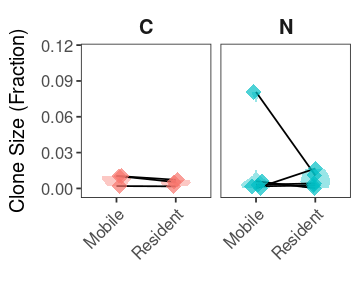

In [85]:
options(repr.plot.width=3, repr.plot.height=2.5)
p <- abund_span %>%
    group_by(SUBJECT, LOCATION, STATUS, SPAN)%>%
    summarize(P = max(P)) %>% filter(LOCATION == "PBMC") %>%
    ggplot(aes(x=SPAN, y=P)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Clone Size (Fraction)")) +
    scale_y_continuous(expand = expand_scale(mult = c(0.1, 0.5))) +
    geom_violin(aes(fill=STATUS), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group = SUBJECT)) +
    geom_point(aes(color=STATUS), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_grid(. ~ STATUS)
plot(p)

### Overall abundances CSF vs PBMC of CD4

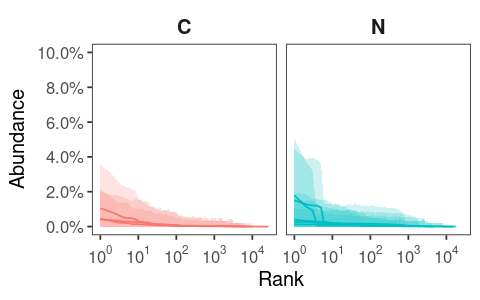

In [90]:
options(repr.plot.width=4, repr.plot.height=2.5)

p <- ggplot(abund %>% filter(LOCATION == "CSF"), aes(x=RANK, y=P, group=SUBJECT)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +
    xlab("Rank") +
    ylab("Abundance") +
    scale_x_log10(breaks=trans_breaks('log10', function(x) 10^x),
                  labels=trans_format('log10', math_format(10^.x))) +
    scale_y_continuous(labels=percent, breaks=seq(0.0, 0.1, 0.02), limits=c(0,0.1)) +
    geom_ribbon(aes(ymin=LOWER, ymax=UPPER, fill=STATUS), alpha=0.2) +
    geom_line(aes(color=STATUS), size=0.5) +
    facet_grid(. ~ STATUS)
plot(p)

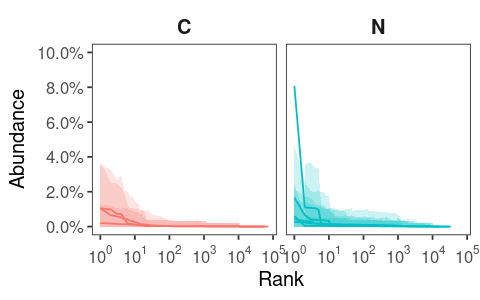

In [91]:
options(repr.plot.width=4, repr.plot.height=2.5)

p <- ggplot(abund %>% filter(LOCATION == "PBMC"), aes(x=RANK, y=P, group=SUBJECT)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +
    xlab("Rank") +
    ylab("Abundance") +
    scale_x_log10(breaks=trans_breaks('log10', function(x) 10^x),
                  labels=trans_format('log10', math_format(10^.x))) +
    scale_y_continuous(labels=percent, breaks=seq(0.0, 0.1, 0.02), limits=c(0,0.10)) +
    geom_ribbon(aes(ymin=LOWER, ymax=UPPER, fill=STATUS), alpha=0.2) +
    geom_line(aes(color=STATUS), size=0.5) +
    facet_grid(. ~ STATUS)
plot(p)

### Overall diversity CSF vs PBMC of CD4

In [92]:
div <- alphaDiversity(hc_df %>% ungroup() %>% filter(SUBSET == "CD4 T cell"), group="SUBJECT_LOCATION", 
                           clone="CLONE", 
                           min_q=0, max_q=2, step_q=2, ci=0.95, nboot=300, min_n=10)

`summarise()` regrouping output by 'SUBJECT_LOCATION' (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` regrouping output by 'SUBJECT_LOCATION' (override with `.groups` argument)


In [93]:
even <- div@diversity %>%
    mutate(SUBJECT = strsplit(SUBJECT_LOCATION, ",")[[1]][1],
          LOCATION = strsplit(SUBJECT_LOCATION, ",")[[1]][2]
          ) %>%
    left_join(meta_df %>% select(SUBJECT, STATUS) %>% distinct())

Joining, by = "SUBJECT"


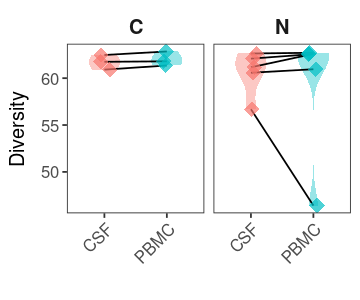

In [95]:
options(repr.plot.width=3, repr.plot.height=2.5)

p <- ggplot(even %>% filter(Q==2), aes(x=LOCATION, y=D)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Diversity")) +
    geom_violin(aes(fill=LOCATION), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group = SUBJECT)) +
    geom_point(aes(color=LOCATION), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_grid(. ~ STATUS)
plot(p)

Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?


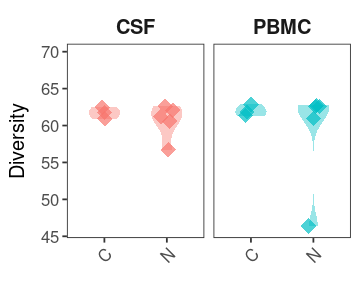

In [97]:
options(repr.plot.width=3, repr.plot.height=2.5)

p <- ggplot(even %>% filter(Q==2), aes(x=STATUS, y=D)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Diversity")) +
    scale_y_continuous(expand = expand_scale(mult = c(0.1, 0.5))) +
    geom_violin(aes(fill=LOCATION), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, wi
    geom_point(aes(color=LOCATION), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_grid(. ~ LOCATION)
plot(p)

# Features of the overlap

In [98]:
div_span <- alphaDiversity(hc_df %>% mutate(SUBJECT_LOCATION_SPAN = paste(SUBJECT_LOCATION, SPAN, sep="@")), 
                           group="SUBJECT_LOCATION_SPAN", 
                           clone="CLONE", 
                           min_q=0, max_q=2, step_q=2, ci=0.95, nboot=200, min_n=10)

`summarise()` regrouping output by 'SUBJECT_LOCATION_SPAN' (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` regrouping output by 'SUBJECT_LOCATION_SPAN' (override with `.groups` argument)


In [99]:
even_span <- div_span@diversity %>%
    rowwise() %>%
    mutate(SUBJECT_LOCATION = strsplit(SUBJECT_LOCATION_SPAN, split ="@")[[1]][1], 
           SPAN = strsplit(SUBJECT_LOCATION_SPAN, split ="@")[[1]][2]) %>%
    mutate(SUBJECT = strsplit(SUBJECT_LOCATION, ",")[[1]][1],
          LOCATION = strsplit(SUBJECT_LOCATION, ",")[[1]][2]
          ) %>%
    left_join(meta_df %>% select(SUBJECT, STATUS) %>% distinct())

Joining, by = "SUBJECT"


Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”

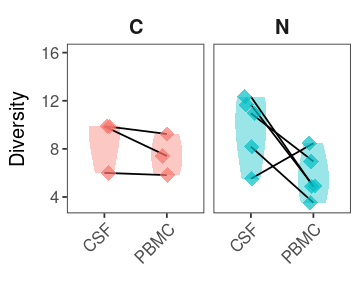

In [100]:
options(repr.plot.width=3, repr.plot.height=2.5)

p <- ggplot(even_span %>% filter(Q==2) %>% filter(SPAN == "Mobile"), aes(x=LOCATION, y=D)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Diversity")) +
    scale_y_continuous(expand = expand_scale(mult = c(0.1, 0.5))) +
    geom_violin(aes(fill=STATUS), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group = SUBJECT)) +
    geom_point(aes(color=STATUS), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_grid(. ~ STATUS)
plot(p)

Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”

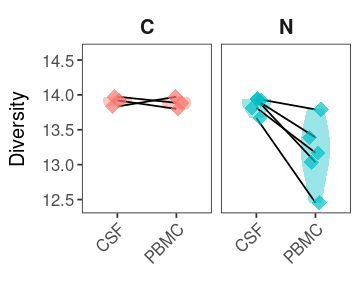

In [102]:
options(repr.plot.width=3, repr.plot.height=2.5)


p <- ggplot(even_span %>% filter(Q==2) %>% filter(SPAN == "Resident"), aes(x=LOCATION, y=D)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Diversity")) +
    scale_y_continuous(expand = expand_scale(mult = c(0.1, 0.5))) +
    geom_violin(aes(fill=STATUS), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group = SUBJECT)) +
    geom_point(aes(color=STATUS), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_grid(. ~ STATUS)
plot(p)

### CD8 T cell diversity resident vs mobile

In [104]:
div_span <- alphaDiversity(hc_df %>% mutate(SUBJECT_LOCATION_SPAN = paste(SUBJECT_LOCATION, SPAN, sep="@")) %>% 
                           filter(SUBSET == "CD8 T cell"), group="SUBJECT_LOCATION_SPAN", 
                           clone="CLONE", 
                           min_q=0, max_q=2, step_q=2, ci=0.95, nboot=200, min_n=10)

`summarise()` regrouping output by 'SUBJECT_LOCATION_SPAN' (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)
Warning message in estimateAbundance(data, ci = 0.95, ...):
“Not all groups passed threshold min_n=10. Excluded: P3,CSF@Mobile”`summarise()` regrouping output by 'SUBJECT_LOCATION_SPAN' (override with `.groups` argument)


In [105]:
even_span <- div_span@diversity %>%
    rowwise() %>%
    mutate(SUBJECT_LOCATION = strsplit(SUBJECT_LOCATION_SPAN, split ="@")[[1]][1], 
           SPAN = strsplit(SUBJECT_LOCATION_SPAN, split ="@")[[1]][2]) %>%
    mutate(SUBJECT = strsplit(SUBJECT_LOCATION, ",")[[1]][1],
          LOCATION = strsplit(SUBJECT_LOCATION, ",")[[1]][2]
          ) %>%
    left_join(meta_df %>% select(SUBJECT, STATUS) %>% distinct())

Joining, by = "SUBJECT"


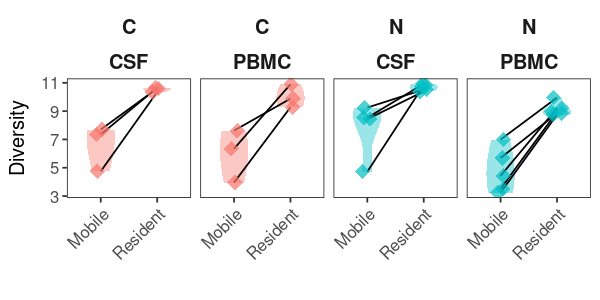

In [106]:
options(repr.plot.width=5, repr.plot.height=2.5)

p <- ggplot(even_span %>% filter(Q==2), aes(x=SPAN, y=D)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Diversity")) +
    geom_violin(aes(fill=STATUS), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group = SUBJECT)) +
    geom_point(aes(color=STATUS), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_grid(. ~ STATUS+LOCATION)
plot(p)

Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”

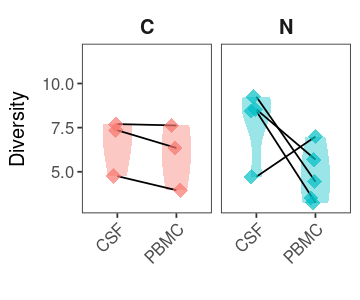

In [108]:
options(repr.plot.width=3, repr.plot.height=2.5)

p <- ggplot(even_span %>% filter(Q==2) %>% filter(SPAN == "Mobile"), aes(x=LOCATION, y=D)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Diversity")) +
    scale_y_continuous(expand = expand_scale(mult = c(0.1, 0.5))) +
    geom_violin(aes(fill=STATUS), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group = SUBJECT)) +
    geom_point(aes(color=STATUS), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_grid(. ~ STATUS)
plot(p)

Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”

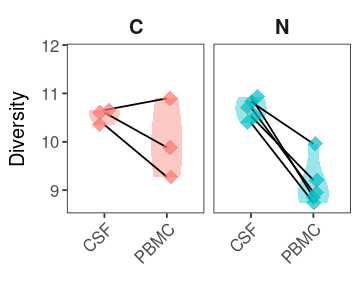

In [111]:
options(repr.plot.width=3, repr.plot.height=2.5)


p <- ggplot(even_span %>% filter(Q==2) %>% filter(SPAN == "Resident"), aes(x=LOCATION, y=D)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Diversity")) +
    scale_y_continuous(expand = expand_scale(mult = c(0.1, 0.5))) +
    geom_violin(aes(fill=STATUS), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group = SUBJECT)) +
    geom_point(aes(color=STATUS), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_grid(. ~ STATUS)
plot(p)

### CD4 T cell diversity resident vs mobile

In [113]:
div_span <- alphaDiversity(hc_df %>% mutate(SUBJECT_LOCATION_SPAN = paste(SUBJECT_LOCATION, SPAN, sep="@")) %>% filter(SUBSET == "CD4 T cell"), group="SUBJECT_LOCATION_SPAN", 
                           clone="CLONE", 
                           min_q=0, max_q=2, step_q=2, ci=0.95, nboot=200, min_n=5)

`summarise()` regrouping output by 'SUBJECT_LOCATION_SPAN' (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)
Warning message in estimateAbundance(data, ci = 0.95, ...):
“Not all groups passed threshold min_n=5. Excluded: P2,CSF@Mobile, P3,CSF@Mobile, P5,CSF@Mobile, P5,PBMC@Mobile”`summarise()` regrouping output by 'SUBJECT_LOCATION_SPAN' (override with `.groups` argument)


In [114]:
even_span <- div_span@diversity %>%
    rowwise() %>%
    mutate(SUBJECT_LOCATION = strsplit(SUBJECT_LOCATION_SPAN, split ="@")[[1]][1], 
           SPAN = strsplit(SUBJECT_LOCATION_SPAN, split ="@")[[1]][2]) %>%
    mutate(SUBJECT = strsplit(SUBJECT_LOCATION, ",")[[1]][1],
          LOCATION = strsplit(SUBJECT_LOCATION, ",")[[1]][2]
          ) %>%
    left_join(meta_df %>% select(SUBJECT, STATUS) %>% distinct())

Joining, by = "SUBJECT"


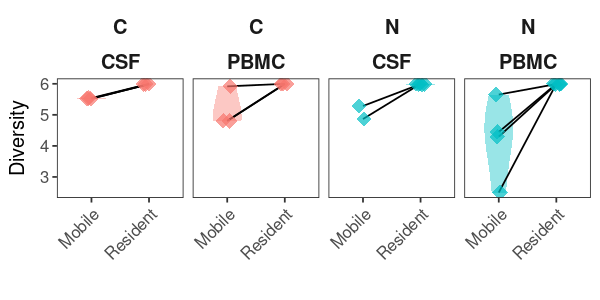

In [116]:
options(repr.plot.width=5, repr.plot.height=2.5)

p <- ggplot(even_span %>% filter(Q==2), aes(x=SPAN, y=D)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Diversity")) +
    geom_violin(aes(fill=STATUS), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group = SUBJECT)) +
    geom_point(aes(color=STATUS), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_grid(. ~ STATUS+LOCATION)
plot(p)

Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”

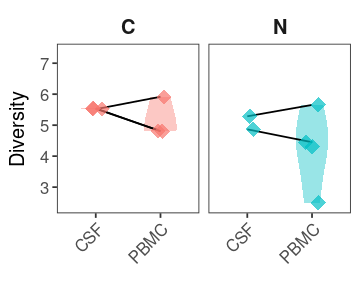

In [118]:
options(repr.plot.width=3, repr.plot.height=2.5)

p <- ggplot(even_span %>% filter(Q==2) %>% filter(SPAN == "Mobile"), aes(x=LOCATION, y=D)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Diversity")) +
    scale_y_continuous(expand = expand_scale(mult = c(0.1, 0.5))) +
    geom_violin(aes(fill=STATUS), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group = SUBJECT)) +
    geom_point(aes(color=STATUS), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_grid(. ~ STATUS)
plot(p)

Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”

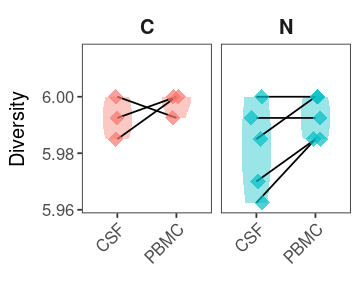

In [120]:
options(repr.plot.width=3, repr.plot.height=2.5)

p <- ggplot(even_span %>% filter(Q==2) %>% filter(SPAN == "Resident"), aes(x=LOCATION, y=D)) + 
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=12), legend.text=element_text(size=10), legend.title=element_text(size=12)) +    xlab("") +
    ylab(expression("Diversity")) +
    scale_y_continuous(expand = expand_scale(mult = c(0.1, 0.5))) +
    geom_violin(aes(fill=STATUS), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group = SUBJECT)) +
    geom_point(aes(color=STATUS), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    facet_grid(. ~ STATUS)
plot(p)

# COVID Specific TCRs
- Identify possible COVID specific TCR sequences https://vdjdb.cdr3.net/search

In [36]:
hc_covid_df <- hc_df %>%
    mutate(JUNCTION_AA = translateDNA(JUNCTION))

In [38]:
covid <- read.csv(file.path(BASE_DIR, 'VDJDb_COVID19.tsv'), sep = '\t') %>%
    filter(Gene == "TRB") %>%
    mutate(SPEC = "COVID") %>%
    select(CDR3, V, J, MHC.class, MHC.A, MHC.B, SPEC, Meta, Method) %>%
    rename(JUNCTION_AA = CDR3, V_COVID = V, J_COVID = J)

In [40]:
covid_hits <- hc_covid_df %>%
    left_join(covid, by = "JUNCTION_AA") %>% drop_na(SPEC) 

In [39]:
covid_hits %>% write.csv(file.path(BASE_DIR, 'VDJDb_COVID19_hits.csv'))

In [49]:
covid_hits %>% select(SUBJECT, SAMPLE, JUNCTION_AA, V_COVID, J_COVID, V_CALL, J_CALL, SUBSET)

SUBJECT SAMPLE JUNCTION_AA   V_COVID    J_COVID    V_CALL     J_CALL    
1 P6      PBMC10 CASSSQNTGELFF TRBV7-8*01 TRBJ2-2*01 TRBV6-5*01 TRBJ2-2*01
2 P6      CSFC1  CASSYQNTGELFF TRBV7-8*01 TRBJ2-2*01 TRBV6-5*01 TRBJ2-2*01
3 P4      CSF4   CASSPEIEAFF   TRBV7-9*01 TRBJ1-1*01 TRBV7-9*03 TRBJ1-1*01
4 P4      CSF4   CASSPEIEAFF   TRBV7-9*01 TRBJ1-1*01 TRBV7-9*03 TRBJ1-1*01
5 P4      CSF4   CASSPEIEAFF   TRBV7-9*01 TRBJ1-1*01 TRBV7-9*03 TRBJ1-1*01
6 P4      CSF4   CASSDGNTGELFF TRBV5-1*01 TRBJ2-2*01 TRBV7-9*03 TRBJ2-2*01
  SUBSET    
1 CD4 T cell
2 CD8 T cell
3 CD8 T cell
4 CD8 T cell
5 CD8 T cell
6 CD8 T cell

In [50]:
read.csv(file.path(BASE_DIR, 'VDJDb_COVID19.tsv'), sep = '\t')

complex.id Gene CDR3              V           J          Species    
1   0          TRA  CAMSGDNYGQNFVF    TRAV12-3*01 TRAJ26*01  HomoSapiens
2   0          TRA  CVRDNYGQNFVF      TRAV10*01   TRAJ26*01  HomoSapiens
3   0          TRA  CVVNEGDKLSF       TRAV12-1*01 TRAJ20*01  HomoSapiens
4   0          TRA  CVVNEVDSGYALNF    TRAV12-1*01 TRAJ41*01  HomoSapiens
5   0          TRA  CVVNNNNDMRF       TRAV12-1*01 TRAJ43*01  HomoSapiens
6   0          TRA  CAVNRDDKIIF       TRAV12-2*01 TRAJ30*01  HomoSapiens
7   0          TRA  CVVNGDNNDMRF      TRAV12-1*01 TRAJ43*01  HomoSapiens
8   0          TRA  CVVNEADKLIF       TRAV12-1*01 TRAJ34*01  HomoSapiens
9   0          TRA  CVVNSAAGNKLTF     TRAV12-1*01 TRAJ17*01  HomoSapiens
10  0          TRA  CVVNNDDKIIF       TRAV12-1*01 TRAJ30*01  HomoSapiens
11  0          TRA  CVVNDYDKLIF       TRAV12-1*01 TRAJ34*01  HomoSapiens
12  0          TRA  CVVNEEDKIIF       TRAV12-1*01 TRAJ30*01  HomoSapiens
13  0          TRA  CVVNRNNDMRF       TRAV12-1*01 TRAJ43*01  HomoSapiens
14  0          TRA  CVVNEGDKLIF       TRAV12-1*01 TRAJ34*01  HomoSapiens
15  0          TRA  CVVNSPQAGTALIF    TRAV12-1*01 TRAJ15*01  HomoSapiens
16  0          TRA  CVVNKVQAGTALIF    TRAV12-1*01 TRAJ15*01  HomoSapiens
17  0          TRA  CVVNKEDRLMF       TRAV12-1*01 TRAJ31*01  HomoSapiens
18  0          TRA  CVVNDPVADTPLVF    TRAV12-1*01 TRAJ29*01  HomoSapiens
19  0          TRA  CVVNRDDKIIF       TRAV12-1*01 TRAJ30*01  HomoSapiens
20  0          TRA  CVVNGDDKIIF       TRAV12-1*01 TRAJ30*01  HomoSapiens
21  0          TRA  CVVNQRDDMRF       TRAV12-1*01 TRAJ43*01  HomoSapiens
22  0          TRA  CVVNRLDALNF       TRAV12-1*01 TRAJ41*01  HomoSapiens
23  0          TRA  CADHKLVF          TRAV25*01   TRAJ47*01  HomoSapiens
24  0          TRA  CVVNMEDKIIF       TRAV12-1*01 TRAJ30*01  HomoSapiens
25  0          TRA  CVVNGAGNMLTF      TRAV12-1*01 TRAJ39*01  HomoSapiens
26  0          TRA  CVVNGDTDKLIF      TRAV12-1*01 TRAJ34*01  HomoSapiens
27  0          TRA  CVVNKYNDMRF       TRAV12-1*01 TRAJ43*01  HomoSapiens
28  0          TRA  CVVNRDNDMRF       TRAV12-1*01 TRAJ43*01  HomoSapiens
29  0          TRA  CVVNNEDDMRF       TRAV12-1*01 TRAJ43*01  HomoSapiens
30  0          TRA  CVVNEGDDMRF       TRAV12-1*01 TRAJ43*01  HomoSapiens
⋮   ⋮          ⋮    ⋮                 ⋮           ⋮          ⋮          
710 0          TRB  CARQDTNTGELFF     TRBV12-3*01 TRBJ2-2*01 HomoSapiens
711 0          TRB  CSARDLAGENTGELFF  TRBV20-1*01 TRBJ2-2*01 HomoSapiens
712 0          TRB  CATQRTNTGELFF     TRBV15*01   TRBJ2-2*01 HomoSapiens
713 0          TRB  CATQAVNTGELFF     TRBV15*01   TRBJ2-2*01 HomoSapiens
714 0          TRB  CSARDRLAQNTGELFF  TRBV20-1*01 TRBJ2-2*01 HomoSapiens
715 0          TRB  CSARGWGNEANTGELFF TRBV20-1*01 TRBJ2-2*01 HomoSapiens
716 0          TRB  CASRSRVEQNTGELFF  TRBV2*01    TRBJ2-2*01 HomoSapiens
717 0          TRB  CSARDFNSWNTGELFF  TRBV20-1*01 TRBJ2-2*01 HomoSapiens
718 0          TRB  CSARDQAAQNTGELFF  TRBV20-1*01 TRBJ2-2*01 HomoSapiens
719 0          TRB  CSVAGFLAVYNEQFF   TRBV29-1*01 TRBJ2-1*01 HomoSapiens
720 0          TRB  CASSFLAGGNTGELFF  TRBV19*01   TRBJ2-2*01 HomoSapiens
721 0          TRB  CASQYSNTGELFF     TRBV3-1*01  TRBJ2-2*01 HomoSapiens
722 0          TRB  CASSLVPEEQYF      TRBV5-1*01  TRBJ2-7*01 HomoSapiens
723 0          TRB  CANGKANTGELFF     TRBV12-3*01 TRBJ2-2*01 HomoSapiens
724 0          TRB  CAIQDLNTGELFF     TRBV13*01   TRBJ2-2*01 HomoSapiens
725 0          TRB  CARGESNTGELFF     TRBV7-8*01  TRBJ2-2*01 HomoSapiens
726 0          TRB  CASTDMNTGELFF     TRBV28*01   TRBJ2-2*01 HomoSapiens
727 0          TRB  CAARDQRDLNTGELFF  TRBV2*01    TRBJ2-2*01 HomoSapiens
728 0          TRB  CASGDLDSIEAFF     TRBV2*01    TRBJ1-1*01 HomoSapiens
729 0          TRB  CASQDQNTGELFF     TRBV19*01   TRBJ2-2*01 HomoSapiens
730 0          TRB  CASSHTNTGELFF     TRBV9*01    TRBJ2-2*01 HomoSapiens
731 0          TRB  CSVEEDRNTGELFF    TRBV29-1*01 TRBJ2-2*01 HomoSapiens
732 0          TRB  CASSDIDTGELFF     TRBV2*01    TRBJ2-2*01 H